In [384]:
from __future__ import print_function
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Lambda, Flatten, Permute 
from keras.layers import merge, Merge, Activation, TimeDistributed, Dense, RepeatVector, recurrent
import numpy as np
from six.moves import range
import keras.backend as K
from sklearn.metrics import accuracy_score

In [385]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, chars, maxlen):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [386]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [387]:
# Parameters for the model and dataset
TRAINING_SIZE = 5000
DIGITS = 2
OPS = 2
INVERT = True
# Try replacing GRU, or SimpleRNN
RNN = recurrent.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
MAXLEN = OPS * DIGITS + OPS - 1

In [388]:
chars = '0123456789+ '
ctable = CharacterTable(chars, MAXLEN)

In [389]:
def generate_data(training_size, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    questions = []
    expected = []
    seen = set()
    print('Generating data... ')
    while len(questions) < training_size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, num_digits + 1))))

        ops = []
        for i in range(num_ops):
            ops.append(f())
        # Skip any addition questions we've already seen
        # Also skip any such that X+Y == Y+X (hence the sorting)
        ops.sort()
        key = tuple(ops)
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN
        q = '+'.join([str(op) for op in ops])
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(sum(ops))
        # Answers can be of maximum size DIGITS + 1
        ans += ' ' * (num_digits + 1 - len(ans))
        if INVERT:
            query = query[::-1]
            ans = ans[::-1]
        questions.append(query)
        expected.append(ans)
    print('Total addition questions:', len(questions))
    
    return questions, expected

In [390]:
def create_train_valid(questions, expected, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    print('Vectorization...')
    X = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
    y = np.zeros((len(questions), num_digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        X[i] = ctable.encode(sentence, maxlen=MAXLEN)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, maxlen=num_digits + 1)

    # Shuffle (X, y) in unison as the later parts of X will almost all be larger digits
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Explicitly set apart 10% for validation data that we never train over
    split_at = len(X) - len(X) / 10
    (X_train, X_val) = (slice_X(X, 0, split_at), slice_X(X, split_at))
    (y_train, y_val) = (y[:split_at], y[split_at:])

    print(X_train.shape)
    print(y_train.shape)
    
    return X_train, y_train, X_val, y_val

In [8]:
def build_model(hidden_size, num_layers, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    # Most simple seq2seq model using encoder-decoder framework
    print('Build model...')
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = RNN(hidden_size, input_shape=(MAXLEN, len(chars)))
    model.add(encoder)
    # For the decoder's input, we repeat the encoded input for each time step
    model.add(RepeatVector(num_digits + 1))
    # The decoder RNN could be multiple layers stacked or a single layer
    for _ in range(num_layers):
        decoder = RNN(hidden_size, return_sequences=True)
        model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    mapper = TimeDistributed(Dense(len(chars)))
    model.add(mapper)
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    encoder_f = K.function(inputs, [encoder.output])
    decoder_f = K.function(inputs, [decoder.output])
    mapper_f = K.function(inputs, [mapper.output])
    
    return model, encoder_f, decoder_f, mapper_f, encoder, decoder, mapper

In [391]:
import theano.tensor as T

def get_Y(X, xmaxlen):
    return X[:, :xmaxlen, :]  # get first xmaxlen elem from time dim

def get_R(X):
    Y, alpha = X[0], X[1]
    ans = K.T.batched_dot(Y, alpha)
    return ans

def stack_R(X):
    r_1, r_2, r_3 = X[0], X[1], X[2]
    ans = K.concatenate([r_1, r_2, r_3], axis=1)
    return ans

def build_att_seq2seq_model(hidden_size, num_layers, num_digits, num_ops, chars):
    SEQ_LEN = num_ops * num_digits + num_ops - 1
    
    main_input = Input(shape=(SEQ_LEN,len(chars)), name='main_input')
    encoder = RNN(hidden_size, 
                  input_shape=(SEQ_LEN, len(chars)),
                  return_sequences=True)(main_input)
    Y = Lambda(get_Y, arguments={"xmaxlen": SEQ_LEN}, name="Y", output_shape=(SEQ_LEN, hidden_size))(encoder)
    WY1 = TimeDistributed(Dense(hidden_size), name="WY1")(Y)
#     WY2 = TimeDistributed(Dense(hidden_size), name="WY2")(Y)
#     WY3 = TimeDistributed(Dense(hidden_size), name="WY3")(Y)
    M1 = Activation('tanh', name="M1")(WY1)
#     M2 = Activation('tanh', name="M2")(WY2)
#     M3 = Activation('tanh', name="M3")(WY3)

    alpha_1 = TimeDistributed(Dense(1, activation='linear'), name="alpha_1")(M1)
    alpha_2 = TimeDistributed(Dense(1, activation='linear'), name="alpha_2")(M1)
    alpha_3 = TimeDistributed(Dense(1, activation='linear'), name="alpha_3")(M1)
    flat_alpha1 = Flatten(name="flat_alpha1")(alpha_1)
    flat_alpha2 = Flatten(name="flat_alpha2")(alpha_2)
    flat_alpha3 = Flatten(name="flat_alpha3")(alpha_3)
    alpha1 = Dense(SEQ_LEN, activation='softmax', name="alpha1")(flat_alpha1)
    alpha2 = Dense(SEQ_LEN, activation='softmax', name="alpha2")(flat_alpha2)
    alpha3 = Dense(SEQ_LEN, activation='softmax', name="alpha3")(flat_alpha3)

    Y_trans = Permute((2, 1), name="y_trans")(Y)  # of shape (None,300,20)

    r_1 = merge([Y_trans, alpha1], output_shape=(hidden_size, 1), name="r_1", mode=get_R)
    r_2 = merge([Y_trans, alpha2], output_shape=(hidden_size, 1), name="r_2", mode=get_R)
    r_3 = merge([Y_trans, alpha3], output_shape=(hidden_size, 1), name="r_3", mode=get_R)
    
    r1 = Reshape((1,hidden_size))(r_1)
    r2 = Reshape((1,hidden_size))(r_2)
    r3 = Reshape((1,hidden_size))(r_3)
    
#     r_1_trans = Permute((2, 1))(r1)
#     r_2_trans = Permute((2, 1))(r2)
#     r_3_trans = Permute((2, 1))(r3)

#     r = RepeatVector(num_digits+1)(r_1)
#     r = T.stack([r_1, r_2, r_3])
    r = merge([r1, r2, r3], mode=stack_R, output_shape=(3, hidden_size))
#     decoder_input = Permute((2, 1))(r)
    decoded_result = RNN(hidden_size, input_shape=(num_digits+1, hidden_size), return_sequences=True)(r)
    mapping = TimeDistributed(Dense(len(chars)))(decoded_result)
    out = Activation('softmax')(mapping)
    
    output = out
    model = Model(input=[main_input], output=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [261]:
from keras.layers import Reshape

def build_seq_model(hidden_size, num_layers, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    # Most simple seq2seq model using encoder-decoder framework
    print('Build model...')
    model = Sequential()
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
    # note: in a situation where your input sequences have a variable length,
    # use input_shape=(None, nb_feature).
    encoder = RNN(hidden_size*(num_digits+1), input_shape=(MAXLEN, len(chars)))
    model.add(encoder)
    # For the decoder's input, we repeat the encoded input for each time step
    model.add(Reshape((num_digits+1, hidden_size)))
    # The decoder RNN could be multiple layers stacked or a single layer
    for _ in range(num_layers):
        decoder = RNN(hidden_size, return_sequences=True)
        model.add(decoder)

    # For each of step of the output sequence, decide which character should be chosen
    mapper = TimeDistributed(Dense(len(chars)))
    model.add(mapper)
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    inputs = [K.learning_phase()] + model.inputs
    encoder_f = K.function(inputs, [encoder.output])
    decoder_f = K.function(inputs, [decoder.output])
    mapper_f = K.function(inputs, [mapper.output])
    
    return model, encoder_f, decoder_f, mapper_f, encoder, decoder, mapper

In [10]:
from keras.layers import Input, merge, TimeDistributedDense
from keras.models import Model

def feedback_model(hidden_size, num_layers, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    ## Alternative model architecture
    encoder_input = Input(shape=(MAXLEN, len(chars)), name = 'encoder_input')
    decoder_input = Input(shape=(num_digits + 1, len(chars)), name = 'decoder_input')

    x = RNN(hidden_size)(encoder_input)
    context_input = RepeatVector(num_digits + 1)(x)
    x = merge([context_input, decoder_input], mode='concat')
    x = RNN(hidden_size, return_sequences=True)(x)

#     loss = TimeDistributed(Dense(len(chars), activation='softmax'))(x)
    loss = TimeDistributedDense(len(chars), activation='softmax')(x)
    
    model_alt = Model(input=[encoder_input, decoder_input], output=[loss])
    model_alt.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model_alt

In [392]:
def learning(model, X_train, y_train, iterations, X_val, y_val):
    y_true = []
    for idx in range(y_val.shape[0]):
        y_true.append(ctable.decode(y_val[idx]))

    val_acc_array = []
    # Train the model each generation and show predictions against the validation dataset
    for iteration in range(1, iterations):
        print()
        print('-' * 50)
        print('Iteration', iteration)
        training_obj = model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=1,
                  validation_data=(X_val, y_val))
        ###
        # Select 10 samples from the validation set at random so we can visualize errors
    #     for i in range(10):
    #         ind = np.random.randint(0, len(X_val))
    #         rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
    #         preds = model.predict_classes(rowX, verbose=0)
    #         q = ctable.decode(rowX[0])
    #         correct = ctable.decode(rowy[0])
    #         guess = ctable.decode(preds[0], calc_argmax=False)
    #         print('Q', q[::-1] if INVERT else q)
    #         print('T', correct)
    #         print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)
    #         print('---')

#         preds = model.predict_classes(X_val, verbose=0)
#         y_preds = []
#         for idx in range(preds.shape[0]):
#             y_preds.append(ctable.decode(preds[idx], calc_argmax=False))

#         acc = accuracy_score(y_true, y_preds)
        acc = training_obj.history['val_acc']
        val_acc_array.append(acc)
        print('Current validation accuracy = ' + str(acc))
    
    return val_acc_array

In [393]:
DIGITS = 2
OPS = 2
TRAINING_SIZE = 5000
questions, expected = generate_data(TRAINING_SIZE, DIGITS, OPS)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, DIGITS, OPS)
# model, encoder_f_, decoder_f_, mapper_f_, encoder, decoder, mapper = build_att_seq2seq_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS, chars)
# val_acc_2_2 = learning(model, X_train, y_train, 50, X_val, y_val)
model = build_att_seq2seq_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS, chars)
val_acc_2_2 = learning(model, X_train, y_train, 50, X_val, y_val)

# y_train_pre = np.zeros(y_train.shape)
# for idx in range(len(y_train_pre)):
#     y_train_pre[idx][1:] = y_train[idx][:-1]
# y_val_pre = np.zeros(y_val.shape)
# for idx in range(len(y_val_pre)):
#     y_val_pre[idx][1:] = y_val[idx][:-1]
    
# fb_model = feedback_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
# fb_val_acc_2_2 = learning(fb_model, [X_train, y_train_pre], y_train, 50, [X_val, y_val_pre], y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 5, 12)
(4500, 3, 12)

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 2.3033 - acc: 0.2388 - val_loss: 2.1453 - val_acc: 0.3120
Current validation accuracy = [0.312]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 3s - loss: 1.9556 - acc: 0.3758 - val_loss: 1.7939 - val_acc: 0.3853
Current validation accuracy = [0.38533333333333336]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 1.7723 - acc: 0.3912 - val_loss: 1.7279 - val_acc: 0.3847
Current validation accuracy = [0.38466666666666671]

--------------------------------------------------
Itera

In [300]:
len(model.layers[3].get_weights()[1])

128

In [11]:
DIGITS = 3
OPS = 3
TRAINING_SIZE = 50000
questions, expected = generate_data(TRAINING_SIZE, DIGITS, OPS)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, DIGITS, OPS)
model = build_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
val_acc_3_3 = learning(model, X_train, y_train, 50, X_val, y_val)

y_train_pre = np.zeros(y_train.shape)
for idx in range(len(y_train_pre)):
    y_train_pre[idx][1:] = y_train[idx][:-1]
y_val_pre = np.zeros(y_val.shape)
for idx in range(len(y_val_pre)):
    y_val_pre[idx][1:] = y_val[idx][:-1]
    
fb_model = feedback_model(HIDDEN_SIZE, LAYERS, DIGITS, OPS)
fb_val_acc_3_3 = learning(fb_model, [X_train, y_train_pre], y_train, 50, [X_val, y_val_pre], y_val)

Generating data... 
Total addition questions: 50000
Vectorization...
(45000, 11, 12)
(45000, 4, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 39s - loss: 1.8136 - acc: 0.3585 - val_loss: 1.6993 - val_acc: 0.3807
Current validation accuracy = [0.38069999999999998]

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 41s - loss: 1.5668 - acc: 0.4196 - val_loss: 1.4374 - val_acc: 0.4574
Current validation accuracy = [0.45745000000000002]

--------------------------------------------------
Iteration 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 40s - loss: 1.3562 - acc: 0.4888 - val_loss: 1.2984 - val_acc: 0.5108
Current validation accuracy = [0.51075000000000004]

--------

/home/CNSHYQH/anaconda2/lib/python2.7/site-packages/Keras-1.0.3-py2.7.egg/keras/layers/core.py:1015: UserWarning: TimeDistributedDense is deprecated, please use TimeDistributed(Dense(...)) instead.
  warnings.warn('TimeDistributedDense is deprecated, '



--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 42s - loss: 1.7630 - acc: 0.3662 - val_loss: 1.6598 - val_acc: 0.3878
Current validation accuracy = [0.38784999999999997]

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 43s - loss: 1.5903 - acc: 0.4066 - val_loss: 1.4825 - val_acc: 0.4408
Current validation accuracy = [0.44080000000000003]

--------------------------------------------------
Iteration 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 42s - loss: 1.4016 - acc: 0.4626 - val_loss: 1.3256 - val_acc: 0.4864
Current validation accuracy = [0.48644999999999999]

--------------------------------------------------
Iteration 4
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
4

In [42]:
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 3, 2)

Vectorization...
(4500, 7, 12)
(4500, 4, 12)


In [43]:
model = build_model(HIDDEN_SIZE, LAYERS, 3, 2)

Build model...


In [44]:
val_acc_3_2 = learning(model, X_train, y_train, 50, X_val, y_val)


--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 2.1080 - acc: 0.2800 - val_loss: 1.9476 - val_acc: 0.3295
Current validation accuracy = [0.32950000214576719]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.8172 - acc: 0.3652 - val_loss: 1.7454 - val_acc: 0.3705
Current validation accuracy = [0.37049999833106995]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 3s - loss: 1.6995 - acc: 0.3834 - val_loss: 1.7012 - val_acc: 0.3735
Current validation accuracy = [0.37350000119209292]

--------------------------------------------------
Iteration 4
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [=======

In [46]:
questions, expected = generate_data(TRAINING_SIZE, 2, 3)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 2, 3)
model = build_model(HIDDEN_SIZE, LAYERS, 2, 3)
val_acc_2_3 = learning(model, X_train, y_train, 50, X_val, y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 8, 12)
(4500, 3, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 2.2378 - acc: 0.2673 - val_loss: 2.0186 - val_acc: 0.3880
Current validation accuracy = [0.38799999690055847]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.8676 - acc: 0.3744 - val_loss: 1.7854 - val_acc: 0.3953
Current validation accuracy = [0.39533333849906921]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 3s - loss: 1.7551 - acc: 0.3833 - val_loss: 1.7257 - val_acc: 0.3833
Current validation accuracy = [0.38333333277702331]

---------------------------

In [48]:
questions, expected = generate_data(TRAINING_SIZE, 3, 3)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 3, 3)
model = build_model(HIDDEN_SIZE, LAYERS, 3, 3)
val_acc_3_3 = learning(model, X_train, y_train, 50, X_val, y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 11, 12)
(4500, 4, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 2.1491 - acc: 0.2719 - val_loss: 1.9375 - val_acc: 0.3605
Current validation accuracy = [0.36049999785423281]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 5s - loss: 1.8317 - acc: 0.3777 - val_loss: 1.8095 - val_acc: 0.3755
Current validation accuracy = [0.37549999952316282]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 1.7611 - acc: 0.3820 - val_loss: 1.7523 - val_acc: 0.3815
Current validation accuracy = [0.38150000119209287]

--------------------------

In [50]:
questions, expected = generate_data(TRAINING_SIZE, 3, 4)
X_train, y_train, X_val, y_val = create_train_valid(questions, expected, 3, 4)
model = build_model(HIDDEN_SIZE, LAYERS, 3, 4)
val_acc_3_4 = learning(model, X_train, y_train, 50, X_val, y_val)

Generating data... 
Total addition questions: 5000
Vectorization...
(4500, 15, 12)
(4500, 4, 12)
Build model...

--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 2.1641 - acc: 0.2753 - val_loss: 1.9400 - val_acc: 0.3530
Current validation accuracy = [0.35299999856948855]

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 4s - loss: 1.9000 - acc: 0.3496 - val_loss: 1.8691 - val_acc: 0.3585
Current validation accuracy = [0.3585000026226044]

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 5s - loss: 1.8458 - acc: 0.3583 - val_loss: 1.8539 - val_acc: 0.3545
Current validation accuracy = [0.35449999856948855]

---------------------------

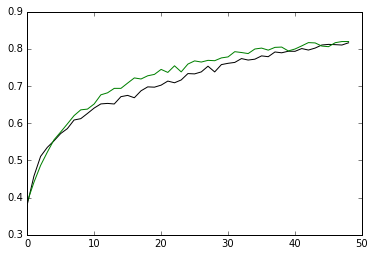

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure()
# plt.plot(fb_val_acc_2_2, 'y')
# plt.plot(val_acc_2_2)
# plt.plot(val_acc_3_2, 'r')
# plt.plot(val_acc_2_3, 'g')
plt.plot(val_acc_3_3, 'k')
plt.plot(fb_val_acc_3_3, 'g')
# plt.plot(val_acc_3_4, 'c')
# plt.legend(['2 digits 2 ops', '3 digits 2 ops', '2 digits 3 ops', '3 digits 3 ops', '3 digits 4 ops'])

In [70]:
# Analysis of the learned encoder-decoder model

In [13]:
def mapper_f(X):
    # The [0] is to disable the training phase flag
    return mapper_f_([0] + [X])

def decoder_f(X):
    # The [0] is to disable the training phase flag
    return decoder_f_([0] + [X])

def encoder_f(X):
    # The [0] is to disable the training phase flag
    return encoder_f_([0] + [X])    

In [404]:
X_str = '81+27'
X_str = X_str[::-1]
print(X_str)
X = ctable.encode(X_str, maxlen=MAXLEN).reshape([1,5,12])
# preds = model.predict_classes(X, verbose=0)
preds = model.predict(X, verbose=0)
# answer = ctable.decode(preds[0], calc_argmax=False)
# print(answer[::-1])
# X = ctable.encode(X_str).reshape([1,5,12])
# W, b = mapper.get_weights()
# mapper_f(X)
# H = decoder_f(X)
X = preds[0].argmax(axis=-1)
''.join(ctable.indices_char[x] for x in X)# ctable.indices_char[x]

72+18


' 23'

In [69]:
type(np.array(K.eval(model.layers[0].W_i)))
a = np.tanh
a(np.array([0.1, 0.2]))
model.layers[0].output_dim

384

In [205]:
class LSTMVisualizer:
    # LSTM weights  
    
    def __sigmoid__(self, x):
        return (1 / (1 + np.exp(-x)))
        
    def __init__(self, LSTM):
        # input gate
        self.W_i = np.array(K.eval(LSTM.W_i))
        self.U_i = np.array(K.eval(LSTM.U_i))
        self.b_i = np.transpose(np.array(K.eval(LSTM.b_i)))

        # forget gate
        self.W_f = np.array(K.eval(LSTM.W_f))
        self.U_f = np.array(K.eval(LSTM.U_f))
        self.b_f = np.transpose(np.array(K.eval(LSTM.b_f)))
        
        # cell
        self.W_c = np.array(K.eval(LSTM.W_c))
        self.U_c = np.array(K.eval(LSTM.U_c))
        self.b_c = np.transpose(np.array(K.eval(LSTM.b_c)))
        
        # output gate
        self.W_o = np.array(K.eval(LSTM.W_o))
        self.U_o = np.array(K.eval(LSTM.U_o))
        self.b_o = np.transpose(np.array(K.eval(LSTM.b_o)))
        
        # activation functions
        self.activation = np.tanh # LSTM.activation
        self.inner_activation = self.__sigmoid__ # LSTM.inner_activation
        
        self.dim = LSTM.output_dim

    def compute(self, X):
        # Initialize h
        H = [np.zeros((self.dim,))]
        C = [np.zeros((self.dim,))]
        I = []
        F = []
        O = []
        
        for x in X:
            # Get previous hidden state
            print('x shape=', x.shape)
            h_tml = H[-1]
            print(h_tml.shape)
            c_tml = C[-1]
            
            x_i = np.inner(np.transpose(self.W_i), x) + self.b_i
            print('x_i.shape=', x_i.shape)
            x_f = np.inner(np.transpose(self.W_f), x) + self.b_f
            x_c = np.inner(np.transpose(self.W_c), x) + self.b_c
            x_o = np.inner(np.transpose(self.W_o), x) + self.b_o

            i = self.inner_activation(x_i + np.inner(np.transpose(self.U_i), H[-1]))
            print('i.shape=', i.shape)
            f = self.inner_activation(x_f + np.inner(np.transpose(self.U_f), H[-1]))
            print(f.shape)
            c_new = self.activation(x_c + np.inner(np.transpose(self.U_c), H[-1]))
            c = np.multiply(f, c_tml) + np.multiply(i, c_new)
            print(c.shape)
            o = self.inner_activation(x_o + np.inner(np.transpose(self.U_o), H[-1]))
            print(o.shape)
            h = np.multiply(o, self.activation(c))
            print(h.shape)
            
            I.append(i)
            F.append(f)
            C.append(c)
            O.append(o)
            H.append(h)
        
        return I, F, C, O, H

print(W[:,4])
np.argmax(W[:,4]), np.max(W[:,4])

In [206]:
X1_str = '95+43'
X1_str = X1_str[::-1]
print(X1_str)
X1 = ctable.encode(X1_str, maxlen=MAXLEN).reshape([1,5,12])
preds1 = model.predict_classes(X1, verbose=0)
answer1 = ctable.decode(preds1[0], calc_argmax=False)
print(answer1[::-1])

X2_str = '65+73'
X2_str = X2_str[::-1]
print(X2_str)
X2 = ctable.encode(X2_str, maxlen=MAXLEN).reshape([1,5,12])
preds2 = model.predict_classes(X2, verbose=0)
answer2 = ctable.decode(preds2[0], calc_argmax=False)
print(answer2[::-1])

34+59
78 
37+56
138


In [233]:
viz = LSTMVisualizer(model.layers[0])
np.transpose(viz.W_i).shape
I1, F1, C1, O1, H1 = viz.compute(X1[0])
I2, F2, C2, O2, H2 = viz.compute(X2[0])

x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)
x shape= (12,)
(384,)
x_i.shape= (384,)
i.shape= (384,)
(384,)
(384,)
(384,)
(384,)


In [237]:
H11 = encoder_f(X1)
H22 = encoder_f(X2)

In [238]:
H11[0][0][:10]-H22[0][0][:10]

array([-0.02621288, -0.41299691,  0.01349065,  0.17890247, -0.28438289,
        0.00558295, -0.06101805, -0.04258914,  0.05178099,  0.20801063])

In [239]:
H1[5][:10]-H2[5][:10]

array([-0.01842767, -0.46913334,  0.01314212,  0.14688788, -0.30514536,
       -0.01535442, -0.07694036, -0.05140045,  0.075449  ,  0.24241088])

In [243]:
H11[0][0][1], H22[0][0][1]

(-0.79272263407823362, -0.37972572291801598)

In [242]:
decoder_f = K.function(decoder.inputs, [decoder.output])

AttributeError: 'LSTM' object has no attribute 'inputs'

In [173]:
H = decoder_f(X)
H[0].shape
np.argmax(H[0][0,0,:]), np.max(H[0][0,0,:])

(121, 0.75900405282036232)

In [272]:
print(chars)
print([ np.inner(H[0][0,0,:], W[:,idx]) for idx in range(12) ])
preds = model.predict_classes(X, verbose=0)
ctable.decode(preds[0], calc_argmax=False)

0123456789+ 
[-4.3513234791601132, -4.9431112475557448, -4.6511908840946461, -8.9641301699517157, -4.4348598222546585, -1.963126190168381, 2.9753856653092701, 8.7274458271487507, 11.555584048872351, 7.987633832776071, 2.0469878540829969, -3.7234760182555617]


'66 '

In [99]:
H[0][0,0,:]

array([-0.06709065,  0.40383556,  0.16411367, -0.74047542, -0.35855955,
       -0.59028941, -0.26894078, -0.66406655, -0.37315661,  0.09656011,
       -0.22731853, -0.56127489, -0.49666747,  0.3873997 ,  0.32721272,
        0.74144036,  0.75600386,  0.50949365,  0.44447297, -0.56334132,
        0.67948729,  0.22404099, -0.18213749,  0.27260011, -0.35370538,
       -0.6508016 ,  0.5779109 , -0.21924061,  0.05315667, -0.39903998,
        0.39056793, -0.        ,  0.15501858, -0.62290728, -0.67472887,
        0.21198085,  0.12123933,  0.52974063, -0.65263051,  0.6788249 ,
        0.47473016, -0.53419101, -0.0291235 ,  0.74110025,  0.        ,
        0.75623643, -0.64309251,  0.39502251,  0.61232328, -0.62432057,
       -0.11690293, -0.01695574,  0.50563914, -0.21612525, -0.32952598,
        0.5745647 ,  0.18968037,  0.7037279 , -0.69483364, -0.62477803,
       -0.57743329, -0.42290473,  0.61531985,  0.26257876, -0.5781849 ,
        0.68098319, -0.73864007, -0.27567244, -0.7042762 ,  0.72

In [100]:
H[0][0,:2,:]

array([[-0.06709065,  0.40383556,  0.16411367, -0.74047542, -0.35855955,
        -0.59028941, -0.26894078, -0.66406655, -0.37315661,  0.09656011,
        -0.22731853, -0.56127489, -0.49666747,  0.3873997 ,  0.32721272,
         0.74144036,  0.75600386,  0.50949365,  0.44447297, -0.56334132,
         0.67948729,  0.22404099, -0.18213749,  0.27260011, -0.35370538,
        -0.6508016 ,  0.5779109 , -0.21924061,  0.05315667, -0.39903998,
         0.39056793, -0.        ,  0.15501858, -0.62290728, -0.67472887,
         0.21198085,  0.12123933,  0.52974063, -0.65263051,  0.6788249 ,
         0.47473016, -0.53419101, -0.0291235 ,  0.74110025,  0.        ,
         0.75623643, -0.64309251,  0.39502251,  0.61232328, -0.62432057,
        -0.11690293, -0.01695574,  0.50563914, -0.21612525, -0.32952598,
         0.5745647 ,  0.18968037,  0.7037279 , -0.69483364, -0.62477803,
        -0.57743329, -0.42290473,  0.61531985,  0.26257876, -0.5781849 ,
         0.68098319, -0.73864007, -0.27567244, -0.7

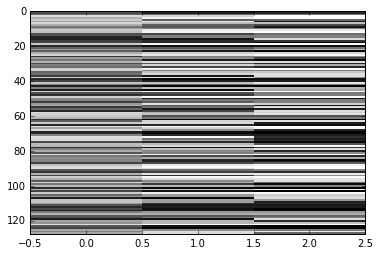

In [101]:
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib.cm as cm
%matplotlib inline

pl.imshow(np.transpose(H[0][0,:3,:]), interpolation='nearest', cmap=cm.binary, aspect='auto')
plt.show()

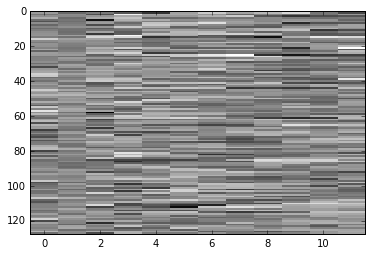

In [102]:
pl.imshow(W, interpolation='nearest', cmap=cm.binary, aspect='auto')
plt.show()

In [103]:
(np.argmax(H[0][0,0,:] * W[:,4]), np.max(H[0][0,0,:] * W[:,4]))

(15, 0.56187469)

In [104]:
(np.argmax(H[0][0,1,:] * W[:,4]), np.max(H[0][0,1,:] * W[:,4]))

(101, 0.62769294)

In [105]:
H[0][0,:3,34]

array([-0.67472887,  0.03123279,  0.        ], dtype=float32)

In [106]:
W[34,:]

array([-0.1932454 , -0.17046466, -0.33151487, -0.28610313, -0.10930867,
       -0.22562845, -0.23864335, -0.23633261,  0.64464188,  0.514768  ,
        0.32287183,  0.23024265], dtype=float32)

In [107]:
(np.argmax(H[0][0,2,:] * W[:,4]), np.max(H[0][0,2,:] * W[:,4]))

(101, 0.65876389)

In [108]:
(np.argmin(H[0][0,2,:] * W[:,4]), np.min(H[0][0,2,:] * W[:,4]))

(24, -0.45415828)

In [109]:
(np.argmin(H[0][0,1,:] * W[:,4]), np.min(H[0][0,1,:] * W[:,4]))

(24, -0.42374974)

In [110]:
np.sort(H[0][0,2,:]*W[:,4])

array([-0.45415828, -0.32855698, -0.29704189, -0.2528812 , -0.24726333,
       -0.22769974, -0.22538853, -0.22083418, -0.20432733, -0.19023129,
       -0.17320378, -0.1695088 , -0.16207343, -0.15740235, -0.14236188,
       -0.14213942, -0.13477033, -0.12927851, -0.12831168, -0.11970972,
       -0.10363259, -0.1032828 , -0.09262865, -0.08448901, -0.07727309,
       -0.07494878, -0.0717946 , -0.06999763, -0.06153421, -0.05854693,
       -0.04606926, -0.04022109, -0.03889963, -0.03877258, -0.03622344,
       -0.03408409, -0.03324113, -0.0290855 , -0.02835351, -0.02560154,
       -0.02457534, -0.02231443, -0.01837168, -0.01154075, -0.00861657,
       -0.00798268, -0.00578552, -0.00291207, -0.00072087, -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.0006604 ,  0.00235866,  0.00646312,  0.01712832,
        0.02227856,  0.02414711,  0.02534644,  0.02723772,  0.02817344,
        0.02962844,  0.04378298,  0.04479284,  0.04778089,  0.05

In [111]:
np.sort(H[0][0,2,:]*W[:,0])

array([ -3.07066858e-01,  -2.36525223e-01,  -1.86790660e-01,
        -1.79153278e-01,  -9.95083377e-02,  -8.52999687e-02,
        -7.92786181e-02,  -5.84232956e-02,  -5.36007360e-02,
        -3.76082137e-02,  -3.74200717e-02,  -2.97356788e-02,
        -2.87593957e-02,  -2.67301910e-02,  -2.66843513e-02,
        -1.54926321e-02,  -1.34472745e-02,  -1.23247402e-02,
        -1.15500055e-02,  -1.06033040e-02,  -9.94192995e-03,
        -9.92942695e-03,  -5.97132975e-03,  -5.30619640e-03,
        -2.57752021e-03,  -1.43820746e-03,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         3.32088035e-04,   1.00557832e-03,   1.51619432e-03,
         4.01117187e-03,   5.09049511e-03,   6.57067867e-03,
         8.09591822e-03,   8.31112824e-03,   1.21207628e-02,
         1.25999600e-02,   1.91498622e-02,   2.13483125e-02,
         2.26804074e-02,   2.47206800e-02,   2.87241414e-02,
         3.08485162e-02,

In [112]:
np.sort(H[0][0,1,:]*W[:,0])

array([-0.5335024 , -0.51823604, -0.50100958, -0.48577577, -0.47957054,
       -0.44241169, -0.37946013, -0.36722139, -0.35580841, -0.33394715,
       -0.23222774, -0.22796875, -0.2009044 , -0.17646785, -0.17416285,
       -0.17232595, -0.16369027, -0.16364257, -0.10973285, -0.10573573,
       -0.1032261 , -0.08143459, -0.0812537 , -0.07862101, -0.07631801,
       -0.07576364, -0.06466574, -0.06453831, -0.06009501, -0.05024419,
       -0.04648986, -0.04348138, -0.04183068, -0.03520668, -0.03504439,
       -0.02873553, -0.02783925, -0.02733363, -0.02595378, -0.01380991,
       -0.01290411, -0.01269832, -0.01256789, -0.00633566, -0.00606702,
       -0.00603559, -0.00495656, -0.00493447, -0.0049248 , -0.00277691,
        0.        , -0.        ,  0.00060533,  0.00067053,  0.00182039,
        0.00437887,  0.00475972,  0.01304994,  0.01382295,  0.01396575,
        0.01528975,  0.01548589,  0.01594696,  0.0162168 ,  0.01740837,
        0.01888322,  0.01985673,  0.02293642,  0.02334398,  0.02

In [113]:
np.sort(H[0][0,2,:]*W[:,4])

array([-0.45415828, -0.32855698, -0.29704189, -0.2528812 , -0.24726333,
       -0.22769974, -0.22538853, -0.22083418, -0.20432733, -0.19023129,
       -0.17320378, -0.1695088 , -0.16207343, -0.15740235, -0.14236188,
       -0.14213942, -0.13477033, -0.12927851, -0.12831168, -0.11970972,
       -0.10363259, -0.1032828 , -0.09262865, -0.08448901, -0.07727309,
       -0.07494878, -0.0717946 , -0.06999763, -0.06153421, -0.05854693,
       -0.04606926, -0.04022109, -0.03889963, -0.03877258, -0.03622344,
       -0.03408409, -0.03324113, -0.0290855 , -0.02835351, -0.02560154,
       -0.02457534, -0.02231443, -0.01837168, -0.01154075, -0.00861657,
       -0.00798268, -0.00578552, -0.00291207, -0.00072087, -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.0006604 ,  0.00235866,  0.00646312,  0.01712832,
        0.02227856,  0.02414711,  0.02534644,  0.02723772,  0.02817344,
        0.02962844,  0.04378298,  0.04479284,  0.04778089,  0.05

In [273]:
np.argsort(H[0][0,0,:]*W[:,8])

array([ 65,  15, 121,  56, 110, 123,  44,  57,  22,  63, 102,  18,  28,
        67, 120,  27, 113,  42, 109,  66, 125,  92, 101,  91,  95,  31,
        45, 103,  87,  83, 127,  26,  94,  11,  99, 117, 106,  82,  76,
        54, 116,  61,  20,  46, 108,  36,  55,   0,  14,  21, 104,  93,
        19,  86, 114,  84,  70,  40, 105, 107,  62, 124,  53,  51,  47,
        29,  72,  50,  74, 115,   7,  35,   2,  81,   9,  23,  80, 122,
        97,  34,  43, 100,  85,  68,  96,  59,  48,   8,  41,  69,  38,
        77, 112, 111,  90,  12,   3,  64, 126,   5,  60,  32,   1,  79,
         6,  24, 118,  25,  13,  17,   4,  89,  16,  71,  52,  88,  75,
        10,  49,  58,  30,  37,  98,  33, 119,  39,  73,  78])

In [275]:
np.argsort(H[0][0,1,:]*W[:,8])

array([ 65,  63, 101,  22,  42,  15,  25,  56,   6,  57, 123,  69,  28,
        39, 125,   1,  44,  92,  19,  26,  66,  45, 114,  83, 106,  91,
        87, 120,  78,  12,  54,  79, 103,  61,  11,  70, 102,  99,  88,
        30, 126,  98,  51,  76,  82,  67,  97,  94, 108,  20, 116,  46,
        93,  55, 127,  27,  21,  36, 105,  84,  40, 118,  62,  72, 109,
        74,  86, 107,  48, 124, 110, 115,  53,  35,   7,   5,  81,   3,
         8,  37, 121, 122, 117,  80,  43,  68,  23,  47,  34, 104, 100,
        29,  18,   9,  60,  50,  77,   0,  59,  41,  38,  32,  90, 111,
        85,  95,  96,   4,  89,  64,   2,  75, 113,  31,  24, 112,  16,
        14,  17,  13,  52,  10,  33,  58,  49, 119,  71,  73])

In [278]:
np.argsort(H[0][0,1,:]*W[:,8])

array([ 73,  39,  30,  98,  17, 123,   4, 112,   6,  24,  65, 125, 106,
       110,  45,  14, 121,  15, 119,   5,  89, 126,  63,  35,  91,  56,
        67,  25, 120,  13,  49,  66,  88, 102,  32,  18,  23, 111,  44,
        57,   9, 109,  53,  27,  19,  38, 115,  28,  86,  74,  40,  36,
       122,  59,  43,  83,  93, 127,  87, 103,  46, 108,  81,  21,  54,
        94,  33,  99,  82,  11,  85,  76,  26,  20,  61,  55, 116,  72,
       105,  84,  92, 117,  51, 101,  69,  62,  47,  70, 124,  12,  31,
       107,  10,  22,  42, 114,  97,   7,  34,   1, 100,  41,  71,  52,
         8,  58,   3,  60,  95,  80,  48,  50,   0,  29,  37,  68,   2,
        79,  75, 104,  77, 113, 118,  96,  16,  64,  90,  78])

In [117]:
dweights = decoder.get_weights()

In [118]:
len(dweights)

12

In [122]:
dweights[3].shape

(128, 128)

In [129]:
context = encoder_f(X)
context = context[0][0]

In [131]:
context

array([-0.71680015, -0.71960968, -0.67189914,  0.35741776, -0.74951118,
       -0.35821265,  0.11314015, -0.44468644, -0.32356325,  0.47177044,
        0.8712455 , -0.49983853,  0.2256813 ,  0.30286032, -0.7024222 ,
       -0.3009218 , -0.2085263 ,  0.48517787, -0.50062698, -0.63945681,
        0.41134304, -0.12710692,  0.35288697, -0.32511729,  0.7333858 ,
        0.63669533, -0.79113978, -0.47415727, -0.70502675, -0.45729491,
        0.94472587, -0.69170535, -0.71485847,  0.53148812, -0.42479914,
        0.79443866, -0.76739752, -0.45804244,  0.63051635, -0.32278904,
       -0.18736556, -0.5895865 , -0.07616945, -0.70557344,  0.09437619,
        0.4516294 , -0.59635127, -0.35728732, -0.60755306, -0.51159179,
        0.83871293, -0.85435426, -0.62628043,  0.24694353,  0.37690449,
       -0.56536186, -0.29809138, -0.42888081, -0.69122845, -0.32909194,
       -0.3422389 ,  0.23144025,  0.79829955, -0.03181538, -0.54385889,
        0.8051672 ,  0.22158965,  0.40830263,  0.48554987, -0.18

In [137]:
dweights[2].shape

(128,)

In [148]:
questions

['  1+0',
 ' 09+1',
 '  9+0',
 ' 27+8',
 '19+34',
 '35+92',
 '  4+1',
 ' 75+6',
 '  8+4',
 '  8+0',
 '  6+5',
 '  6+2',
 ' 55+6',
 '  5+3',
 '53+92',
 '  3+2',
 ' 38+1',
 ' 54+2',
 '38+93',
 ' 97+6',
 ' 47+1',
 '  7+3',
 '  5+4',
 ' 06+9',
 ' 67+8',
 ' 92+5',
 '  6+4',
 ' 22+3',
 '57+36',
 '89+03',
 '67+05',
 '57+45',
 '94+43',
 ' 52+9',
 ' 22+5',
 ' 81+2',
 '66+42',
 ' 81+6',
 '69+03',
 '  2+1',
 '78+51',
 ' 65+1',
 ' 94+8',
 '09+57',
 '  5+2',
 ' 57+2',
 ' 53+3',
 ' 74+9',
 ' 05+0',
 '69+12',
 ' 05+9',
 '98+31',
 ' 47+6',
 '86+25',
 '46+82',
 ' 26+0',
 ' 68+6',
 ' 01+5',
 '96+62',
 '  7+5',
 ' 76+7',
 ' 72+5',
 '39+12',
 '  9+8',
 '16+41',
 ' 35+0',
 '08+97',
 ' 84+7',
 ' 23+1',
 ' 59+2',
 ' 11+1',
 ' 21+0',
 '27+46',
 '  6+0',
 '35+44',
 ' 81+8',
 ' 95+4',
 ' 27+5',
 '47+05',
 '96+54',
 ' 72+7',
 '39+27',
 '  7+2',
 ' 58+7',
 ' 26+2',
 ' 64+7',
 '35+52',
 '  7+4',
 ' 77+1',
 '05+91',
 '76+43',
 ' 66+7',
 '36+93',
 ' 69+4',
 '45+53',
 ' 91+8',
 '  9+4',
 '49+67',
 '81+01',
 ' 08+2',


In [150]:
[s for s in questions if '2' in s and '4' in s]

[' 54+2',
 '66+42',
 '46+82',
 '27+46',
 '44+82',
 ' 12+4',
 '92+42',
 '  4+2',
 '28+04',
 ' 52+4',
 '27+04',
 ' 21+4',
 ' 74+2',
 ' 49+2',
 '74+12',
 '64+22',
 '08+42',
 ' 02+4',
 '29+46',
 '74+62',
 '42+51',
 '94+82',
 '47+92',
 '14+02',
 ' 27+4',
 ' 84+2',
 ' 25+4',
 '34+02',
 ' 23+4',
 '25+34',
 '04+02',
 ' 42+9',
 '24+21',
 ' 22+4',
 ' 41+2',
 ' 24+4',
 ' 62+4',
 ' 64+2',
 ' 42+5',
 '94+22',
 '87+42',
 '54+32',
 '79+42',
 ' 42+1',
 '25+74',
 '26+04',
 '49+23',
 ' 24+1',
 '94+42',
 '47+62',
 '29+14',
 ' 43+2',
 '16+42',
 '94+92',
 '67+24',
 '03+42',
 ' 42+6',
 '18+24',
 ' 29+4',
 '42+32',
 '69+24',
 '44+52',
 '89+42',
 '24+24',
 '24+81',
 ' 42+0',
 '48+32',
 '36+24',
 '46+62',
 '49+52',
 ' 82+4',
 ' 24+3',
 '48+92',
 '84+52',
 '46+72',
 '64+42',
 '92+41',
 '48+12',
 '38+24',
 ' 24+8',
 '29+54',
 ' 24+9',
 '09+24',
 ' 14+2',
 ' 28+4',
 '65+42',
 '24+71',
 '14+12',
 '94+72',
 '64+92',
 '48+42',
 ' 34+2',
 ' 24+0',
 ' 48+2',
 '23+41',
 '26+94',
 '43+21',
 '24+53',
 ' 24+7',
 '47+27',
